In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

In [2]:
exp = {'px_per_deg': 27,
      'N_trials': 400,
      'N_blocks': 1,
      'list_events': ['StimulusOn\n', 'StimulusOff\n',
                      'TargetOn\n', 'TargetOff\n']}

In [3]:
def moulti_fit(sujet, trial, nb_fit=50, perturbation=200):
    
    if sujet < 13 : datafile = 'data/new_data/s%sBLa50.asc'%(sujet)
    else :          datafile = 'data/new_data/s%sBL50.asc'%(sujet)
    #data = read_edf(datafile, 'Trialinfo')
    data_full = read_edf(datafile, 'Trialinfo')
    
    exp['dir_target'] = [[]]
    for t in range(exp['N_trials']) :
        if data_full[t]['events']['msg'][0][1][-2] in ['0','2'] : exp['dir_target'][0].append(1)
        else :                                                    exp['dir_target'][0].append(0)
            
    
    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    #= 1 ===============================================================================================
    Plot.plot_fit(data_full, trials=trial, fig_width=30)

    arg = A.arg(data_full[trial], trial=trial, block=0)
    velocity = A.velocity_NAN(**arg)
    old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)
    rere = Fit.Fit_trial(velocity, value_latency=old_latency, value_steady_state=old_steady_state, value_anti=old_anti, **arg)
    
    result_full_data = rere.values
    for k in ['latency', 'start_anti'] :
        result_full_data[k] = result_full_data[k] - (arg.TargetOn-arg.t_0)
    #print('result_full_data =', result_full_data)

    #= 2 ===============================================================================================
    color = 'g'
    result_red_data = []
    
    #-------------------------------------------------------------------------------
    max_latency = len(arg.trackertime[:-280])
    
    #-------------------------------------------------------------------------------
    np.random.seed(10)
    if old_latency >= max_latency-50 : old_latency = max_latency-150
    if old_latency > 250 :             old_latency = arg.TargetOn-arg.t_0+100
    if np.isnan(old_latency) :         old_latency = arg.TargetOn-arg.t_0+100
    list_latency = old_latency + perturbation*np.random.rand(nb_fit)*np.random.choice([-1,1], nb_fit)
    print(list_latency)
    
    #-------------------------------------------------------------------------------
    for value_latency in list_latency :

        param_fit=[{'name':'steady_state', 'value':old_steady_state, 'min':5., 'max':40., 'vary':True},
                   {'name':'dir_target',   'value':arg.dir_target,   'min':None, 'max':None, 'vary':False},
                   {'name':'a_anti',       'value':old_anti,         'min':-40., 'max':40., 'vary':True},
                   {'name':'latency',      'value':value_latency,
                      'min':arg.TargetOn-arg.t_0+75, 'max':max_latency, 'vary':True},
                   {'name':'start_anti',   'value':arg.TargetOn-arg.t_0-100,
                      'min':arg.StimulusOf-arg.t_0-200, 'max':arg.TargetOn-arg.t_0+75, 'vary':'vary'},
                   {'name':'tau',  'value':15., 'min':13., 'max':80., 'vary':'vary'}]
        inde_vars={'x':np.arange(len(arg.trackertime[:-280]))}

        #===================================================================
        rere = Fit.Fit_trial(velocity, param_fit=param_fit, inde_vars=inde_vars, time_sup=280)
        result_red = rere.values

        fit = A.Equation.fct_velocity(arg.trackertime[:-280]-arg.t_0, **result_red)
        plt.plot(arg.trackertime[:-280]-arg.TargetOn, fit, c=color)

        for k in ['latency', 'start_anti'] : result_red[k] = result_red[k] - (arg.TargetOn-arg.t_0)
        result_red_data.append(result_red)

    return(result_full_data, result_red_data)

In [4]:
def histoto(result_full_data_, result_red_data_, name, color, bins=50):
    
    
    x_range = {'steady_state': [ 5,  40], 'a_anti':     [ -40, 40],
               'latency':      [75, 500], 'start_anti': [-500, 75],
               'tau':          [13,  80]}
    
    list_, list_var = result_full_data_[0].keys(), []
    for v in list_: 
        if v not in ['dir_target', 'do_whitening'] : list_var.append(v)

    nb_var = len(list_var)
    fig, ax = plt.subplots(nb_var, len(result_full_data_), figsize=(5*len(result_full_data_),5*nb_var/1.681))
    
    for r in range(len(result_full_data_)) :
        
        result_full_data = result_full_data_[r]
        result_red_data = result_red_data_[r]
        
        
        for nb_var, v in enumerate(list_var) :
        
            result_v = []
            for n in range(len(result_red_data)) :
                result_v.append(result_red_data[n][v])

            hi = ax[nb_var][r].hist(result_v, range=x_range[v], color=color[r], alpha=.7, density=True, bins=bins)#, histtype='step', align='mid')
            ax[nb_var][r].bar(result_full_data[v], np.max(hi[0]), width=(x_range[v][0]-x_range[v][1])/(bins*2), color='k')    
            ax[nb_var][r].set_title(v+name[r], fontsize=20)
            
            ax[nb_var][r].text(x_range[v][1]-(x_range[v][1]-x_range[v][0])/50,
                               np.max(hi[0])-np.max(hi[0])/50,
                               'true: %.1f\nmean: %.1f +/- %.1f'%(result_full_data[v], np.mean(result_v), np.std(result_v)),
                               ha='right', va='top', fontsize=20)
    plt.tight_layout()

# Good

[1280.26412865 1121.84961013  999.27035301 1275.76077651 1026.29859754
 1081.04067089 1165.61257295  973.89385756 1092.17783269 1108.33203717
  988.92803633  935.32133076 1125.21034673 1228.43845268 1288.52419233
 1248.50521337  981.64893651 1067.62478637  942.4451755  1268.91515668
 1234.5088736  1154.43400952 1200.66815201  991.17327699 1214.36663488
 1039.19720133 1249.55339569 1228.62764851 1256.07943639 1005.79220932
  964.95536063 1230.32943048 1307.72977616 1189.8472178  1107.90813015
 1065.85998867 1103.20312763  960.26373474 1116.62073612 1251.25742966
 1235.51723118 1289.85739913 1165.78950794  954.62993951 1196.33052789
 1276.92953831 1066.80765862  949.21270409 1060.89767243 1159.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


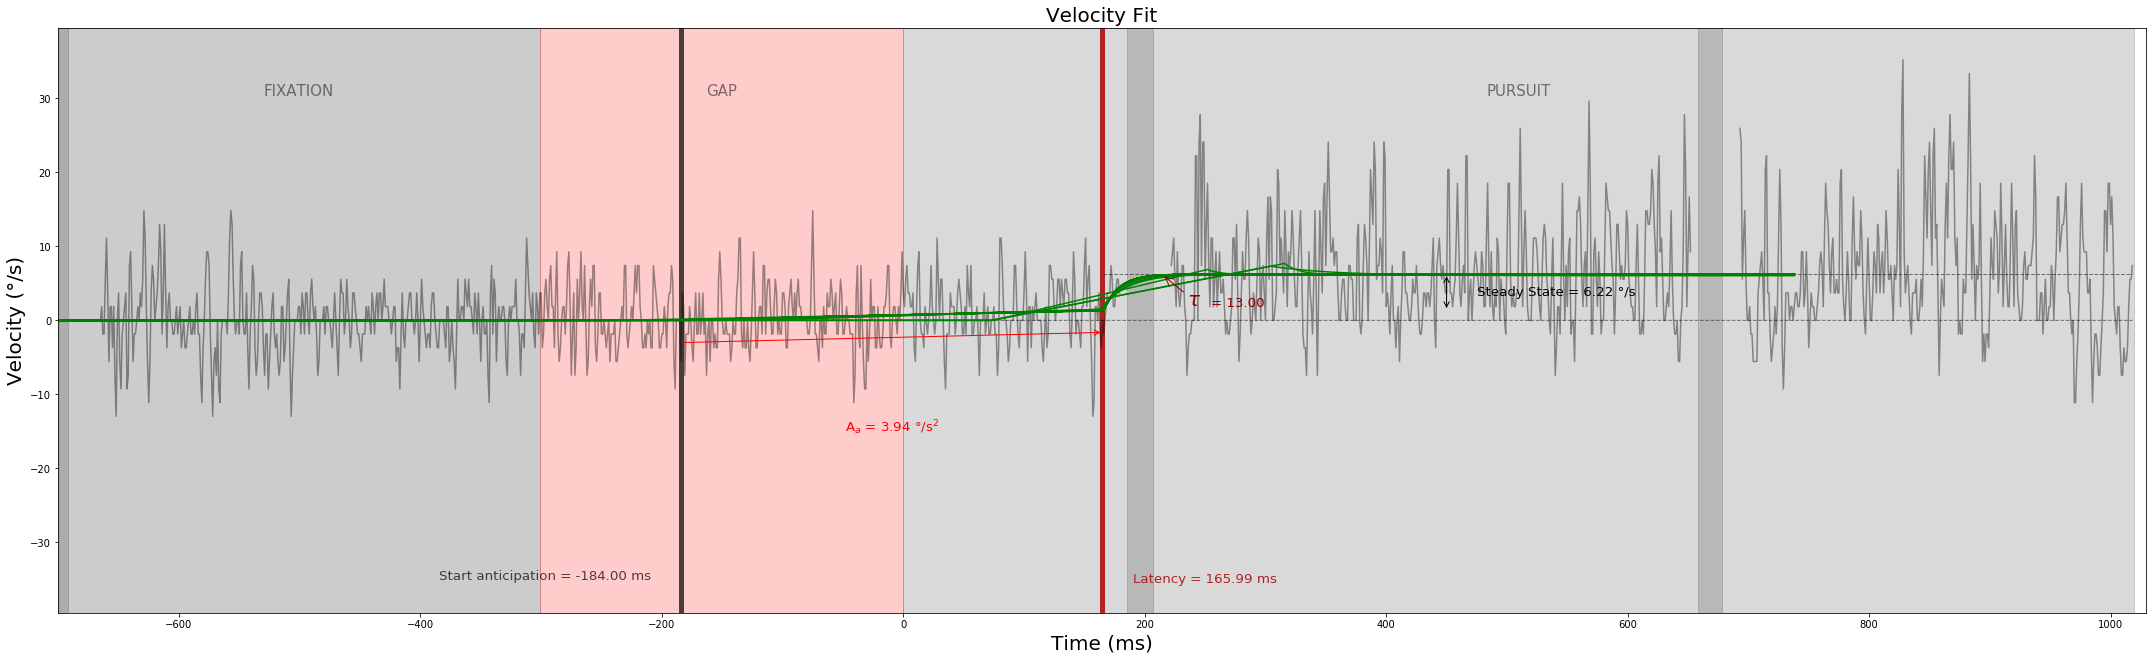

In [5]:
s, t = 1, 11
result_full_data_s1, result_red_data_s1 = moulti_fit(s, t)

[1290.26412865 1131.84961013 1009.27035301 1285.76077651 1036.29859754
 1091.04067089 1175.61257295  983.89385756 1102.17783269 1118.33203717
  998.92803633  945.32133076 1135.21034673 1238.43845268 1298.52419233
 1258.50521337  991.64893651 1077.62478637  952.4451755  1278.91515668
 1244.5088736  1164.43400952 1210.66815201 1001.17327699 1224.36663488
 1049.19720133 1259.55339569 1238.62764851 1266.07943639 1015.79220932
  974.95536063 1240.32943048 1317.72977616 1199.8472178  1117.90813015
 1075.85998867 1113.20312763  970.26373474 1126.62073612 1261.25742966
 1245.51723118 1299.85739913 1175.78950794  964.62993951 1206.33052789
 1286.92953831 1076.80765862  959.21270409 1070.89767243 1169.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

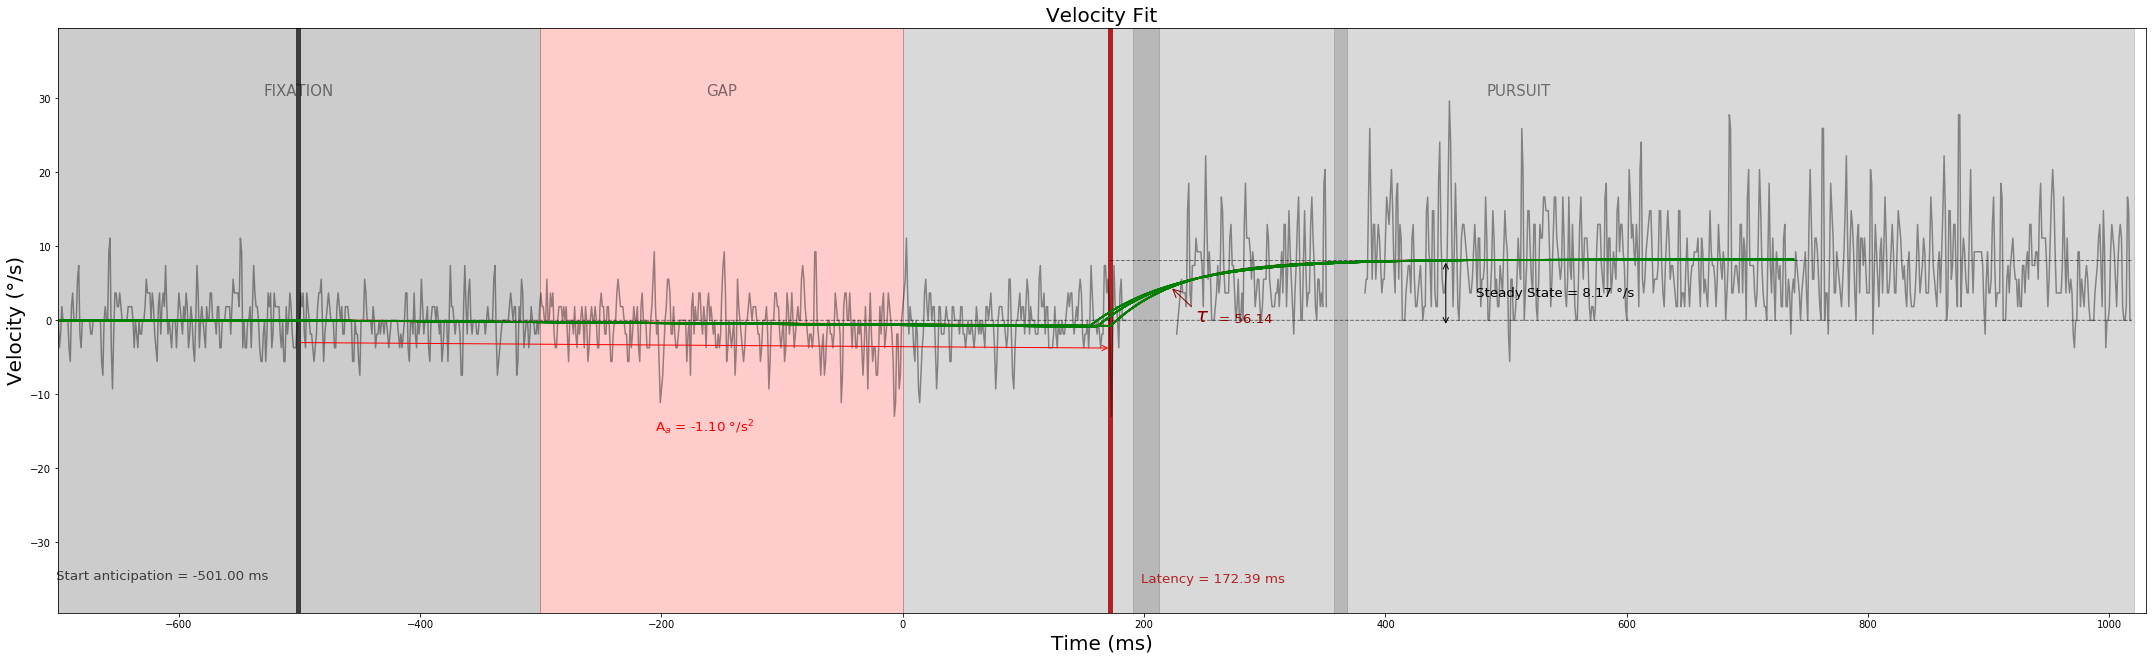

In [6]:
s, t = 2, 11
result_full_data_s2, result_red_data_s2 = moulti_fit(s, t)

[1271.26412865 1112.84961013  990.27035301 1266.76077651 1017.29859754
 1072.04067089 1156.61257295  964.89385756 1083.17783269 1099.33203717
  979.92803633  926.32133076 1116.21034673 1219.43845268 1279.52419233
 1239.50521337  972.64893651 1058.62478637  933.4451755  1259.91515668
 1225.5088736  1145.43400952 1191.66815201  982.17327699 1205.36663488
 1030.19720133 1240.55339569 1219.62764851 1247.07943639  996.79220932
  955.95536063 1221.32943048 1298.72977616 1180.8472178  1098.90813015
 1056.85998867 1094.20312763  951.26373474 1107.62073612 1242.25742966
 1226.51723118 1280.85739913 1156.78950794  945.62993951 1187.33052789
 1267.92953831 1057.80765862  940.21270409 1051.89767243 1150.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

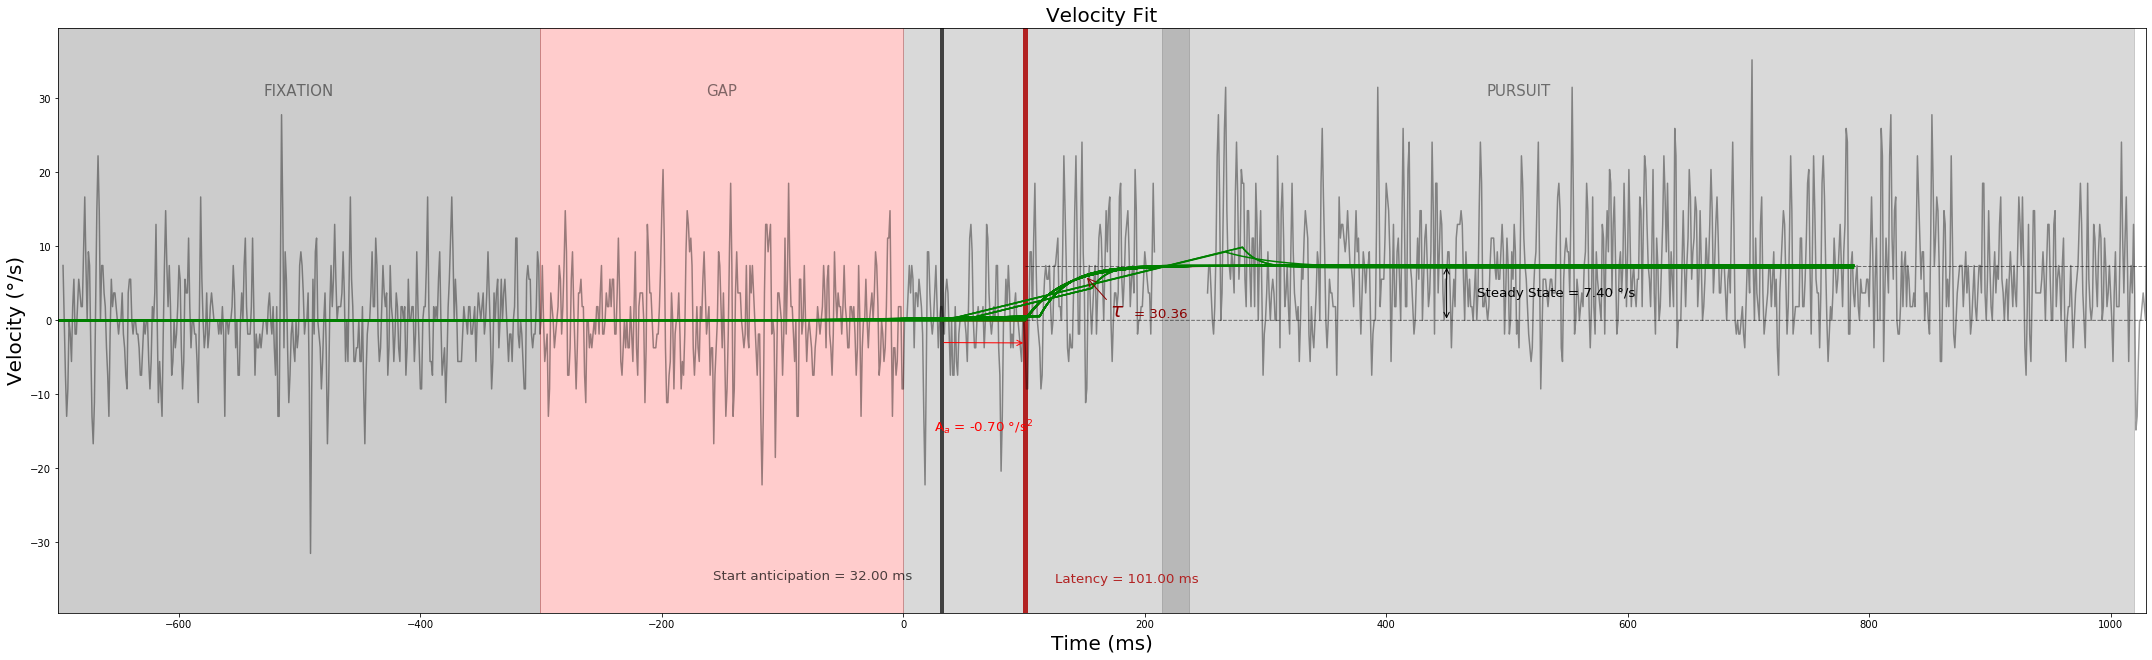

In [7]:
s, t = 3, 11
result_full_data_s3, result_red_data_s3 = moulti_fit(s, t)

[1271.26412865 1112.84961013  990.27035301 1266.76077651 1017.29859754
 1072.04067089 1156.61257295  964.89385756 1083.17783269 1099.33203717
  979.92803633  926.32133076 1116.21034673 1219.43845268 1279.52419233
 1239.50521337  972.64893651 1058.62478637  933.4451755  1259.91515668
 1225.5088736  1145.43400952 1191.66815201  982.17327699 1205.36663488
 1030.19720133 1240.55339569 1219.62764851 1247.07943639  996.79220932
  955.95536063 1221.32943048 1298.72977616 1180.8472178  1098.90813015
 1056.85998867 1094.20312763  951.26373474 1107.62073612 1242.25742966
 1226.51723118 1280.85739913 1156.78950794  945.62993951 1187.33052789
 1267.92953831 1057.80765862  940.21270409 1051.89767243 1150.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

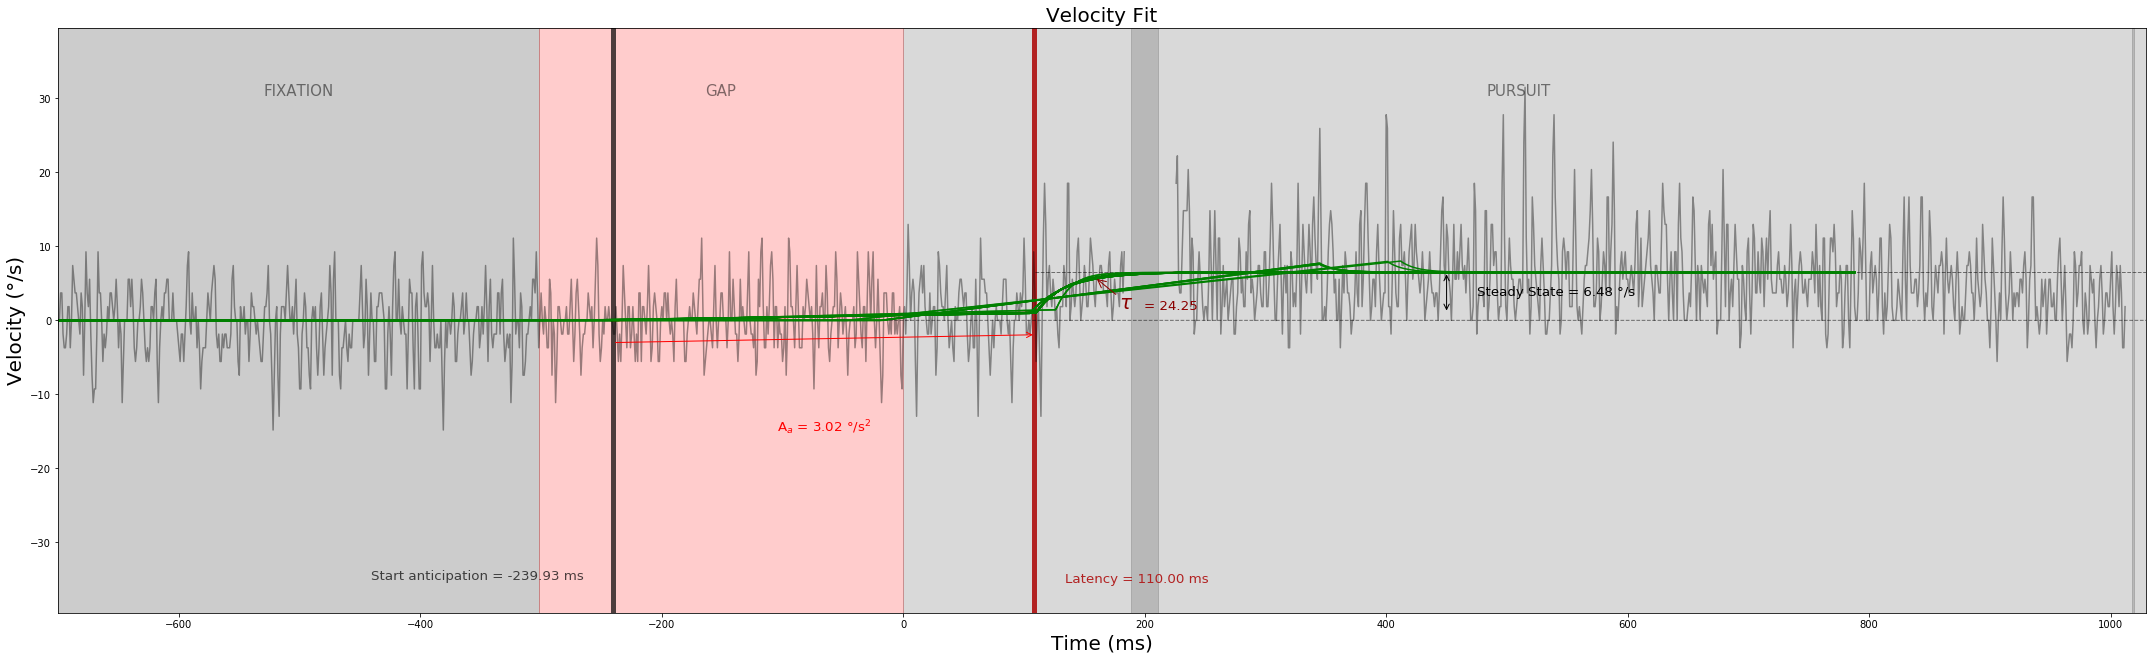

In [8]:
s, t = 4, 11
result_full_data_s4, result_red_data_s4 = moulti_fit(s, t)

# Bad

[1201.26412865 1042.84961013  920.27035301 1196.76077651  947.29859754
 1002.04067089 1086.61257295  894.89385756 1013.17783269 1029.33203717
  909.92803633  856.32133076 1046.21034673 1149.43845268 1209.52419233
 1169.50521337  902.64893651  988.62478637  863.4451755  1189.91515668
 1155.5088736  1075.43400952 1121.66815201  912.17327699 1135.36663488
  960.19720133 1170.55339569 1149.62764851 1177.07943639  926.79220932
  885.95536063 1151.32943048 1228.72977616 1110.8472178  1028.90813015
  986.85998867 1024.20312763  881.26373474 1037.62073612 1172.25742966
 1156.51723118 1210.85739913 1086.78950794  875.62993951 1117.33052789
 1197.92953831  987.80765862  870.21270409  981.89767243 1080.00317954]


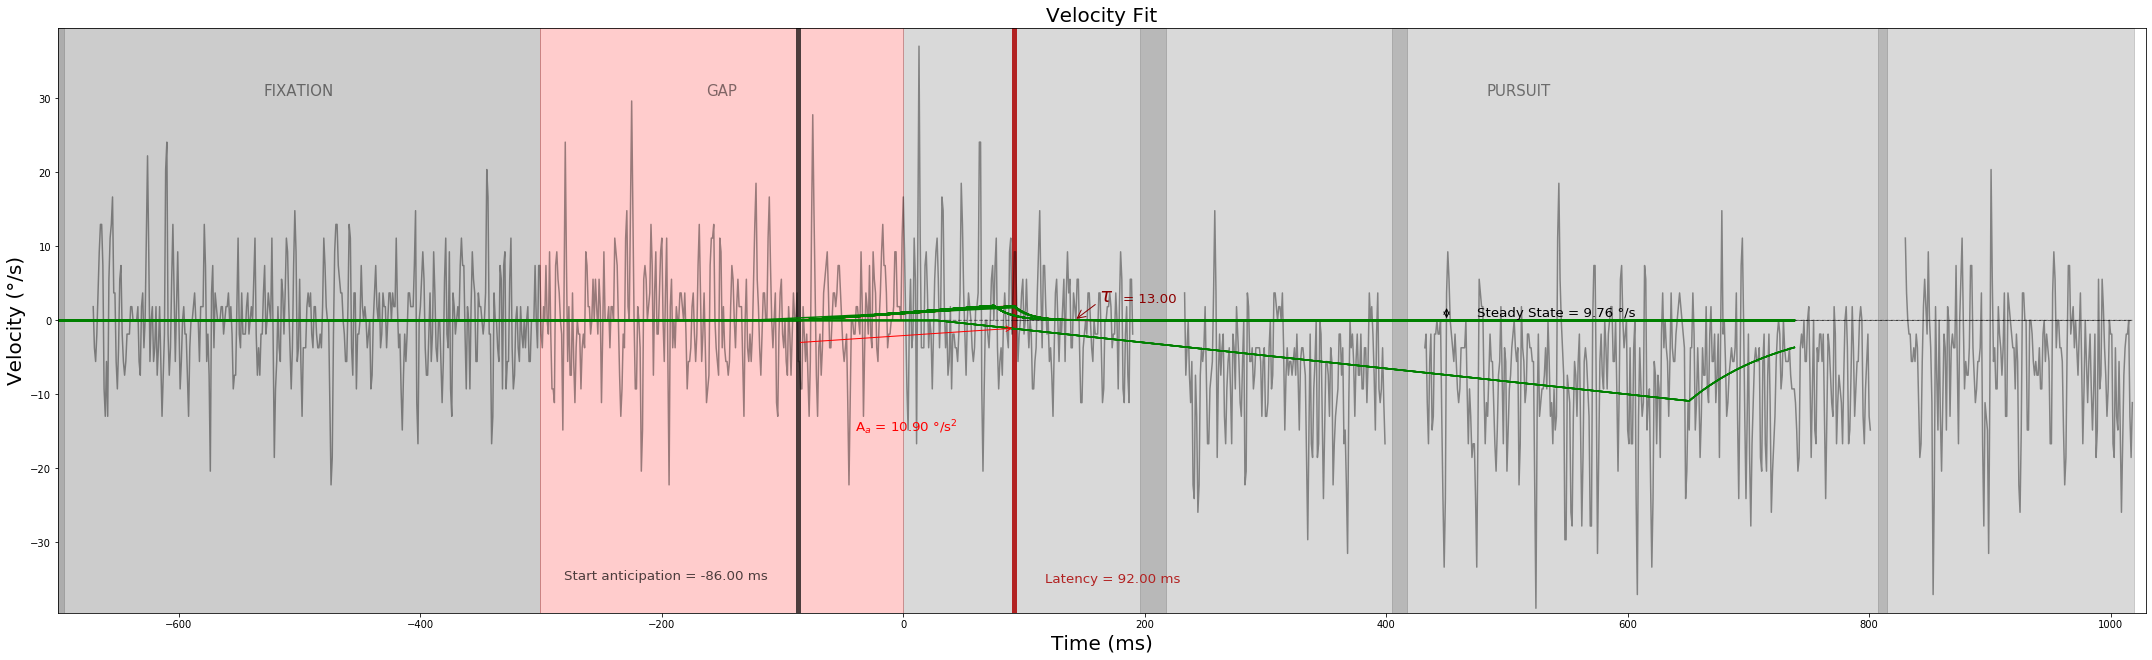

In [9]:
s, t = 1, 391
result_full_data_s1_391, result_red_data_s1_391 = moulti_fit(s, t)

[1160.26412865 1001.84961013  879.27035301 1155.76077651  906.29859754
  961.04067089 1045.61257295  853.89385756  972.17783269  988.33203717
  868.92803633  815.32133076 1005.21034673 1108.43845268 1168.52419233
 1128.50521337  861.64893651  947.62478637  822.4451755  1148.91515668
 1114.5088736  1034.43400952 1080.66815201  871.17327699 1094.36663488
  919.19720133 1129.55339569 1108.62764851 1136.07943639  885.79220932
  844.95536063 1110.32943048 1187.72977616 1069.8472178   987.90813015
  945.85998867  983.20312763  840.26373474  996.62073612 1131.25742966
 1115.51723118 1169.85739913 1045.78950794  834.62993951 1076.33052789
 1156.92953831  946.80765862  829.21270409  940.89767243 1039.00317954]


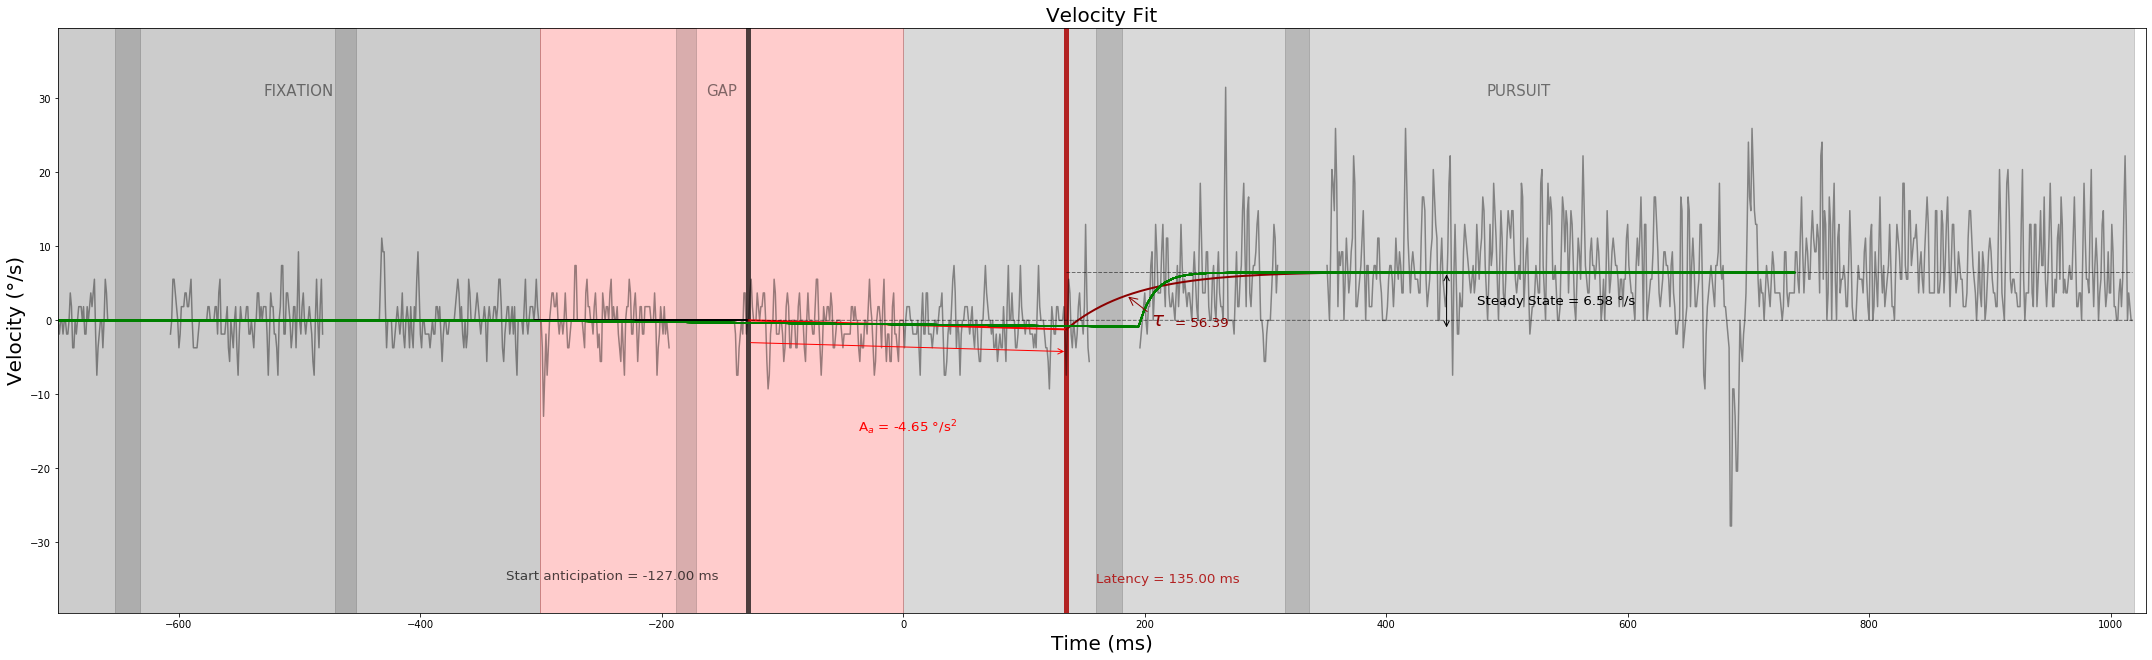

In [10]:
s, t = 2, 18
result_full_data_s2_18, result_red_data_s2_18 = moulti_fit(s, t)

[1050.26412865  891.84961013  769.27035301 1045.76077651  796.29859754
  851.04067089  935.61257295  743.89385756  862.17783269  878.33203717
  758.92803633  705.32133076  895.21034673  998.43845268 1058.52419233
 1018.50521337  751.64893651  837.62478637  712.4451755  1038.91515668
 1004.5088736   924.43400952  970.66815201  761.17327699  984.36663488
  809.19720133 1019.55339569  998.62764851 1026.07943639  775.79220932
  734.95536063 1000.32943048 1077.72977616  959.8472178   877.90813015
  835.85998867  873.20312763  730.26373474  886.62073612 1021.25742966
 1005.51723118 1059.85739913  935.78950794  724.62993951  966.33052789
 1046.92953831  836.80765862  719.21270409  830.89767243  929.00317954]


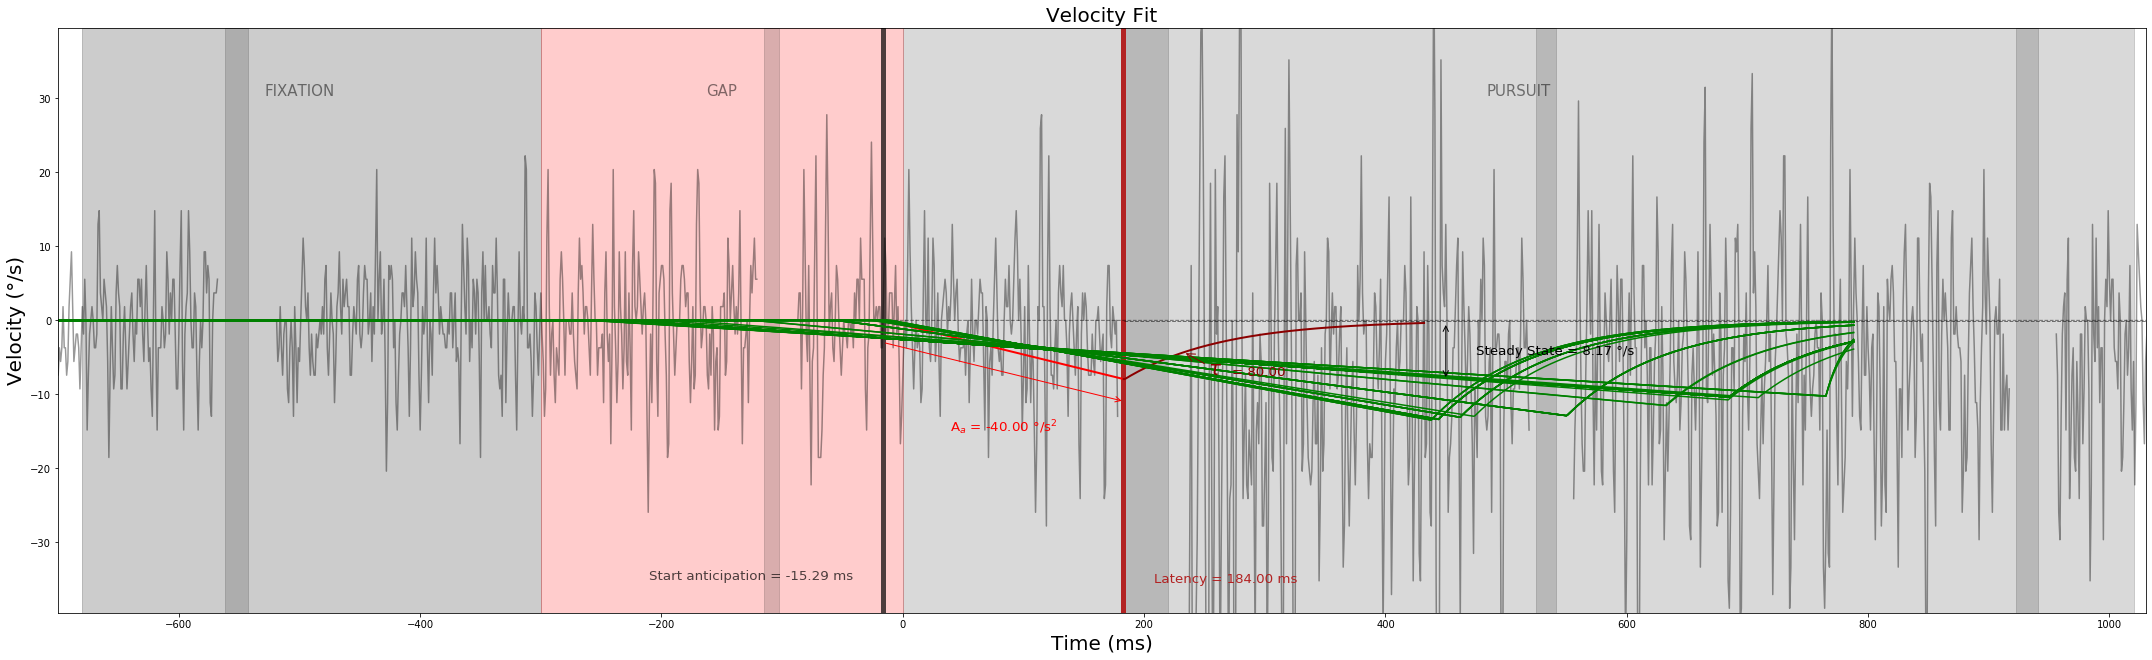

In [11]:
s, t = 3, 61
result_full_data_s3_61, result_red_data_s3_61 = moulti_fit(s, t)

[1201.26412865 1042.84961013  920.27035301 1196.76077651  947.29859754
 1002.04067089 1086.61257295  894.89385756 1013.17783269 1029.33203717
  909.92803633  856.32133076 1046.21034673 1149.43845268 1209.52419233
 1169.50521337  902.64893651  988.62478637  863.4451755  1189.91515668
 1155.5088736  1075.43400952 1121.66815201  912.17327699 1135.36663488
  960.19720133 1170.55339569 1149.62764851 1177.07943639  926.79220932
  885.95536063 1151.32943048 1228.72977616 1110.8472178  1028.90813015
  986.85998867 1024.20312763  881.26373474 1037.62073612 1172.25742966
 1156.51723118 1210.85739913 1086.78950794  875.62993951 1117.33052789
 1197.92953831  987.80765862  870.21270409  981.89767243 1080.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

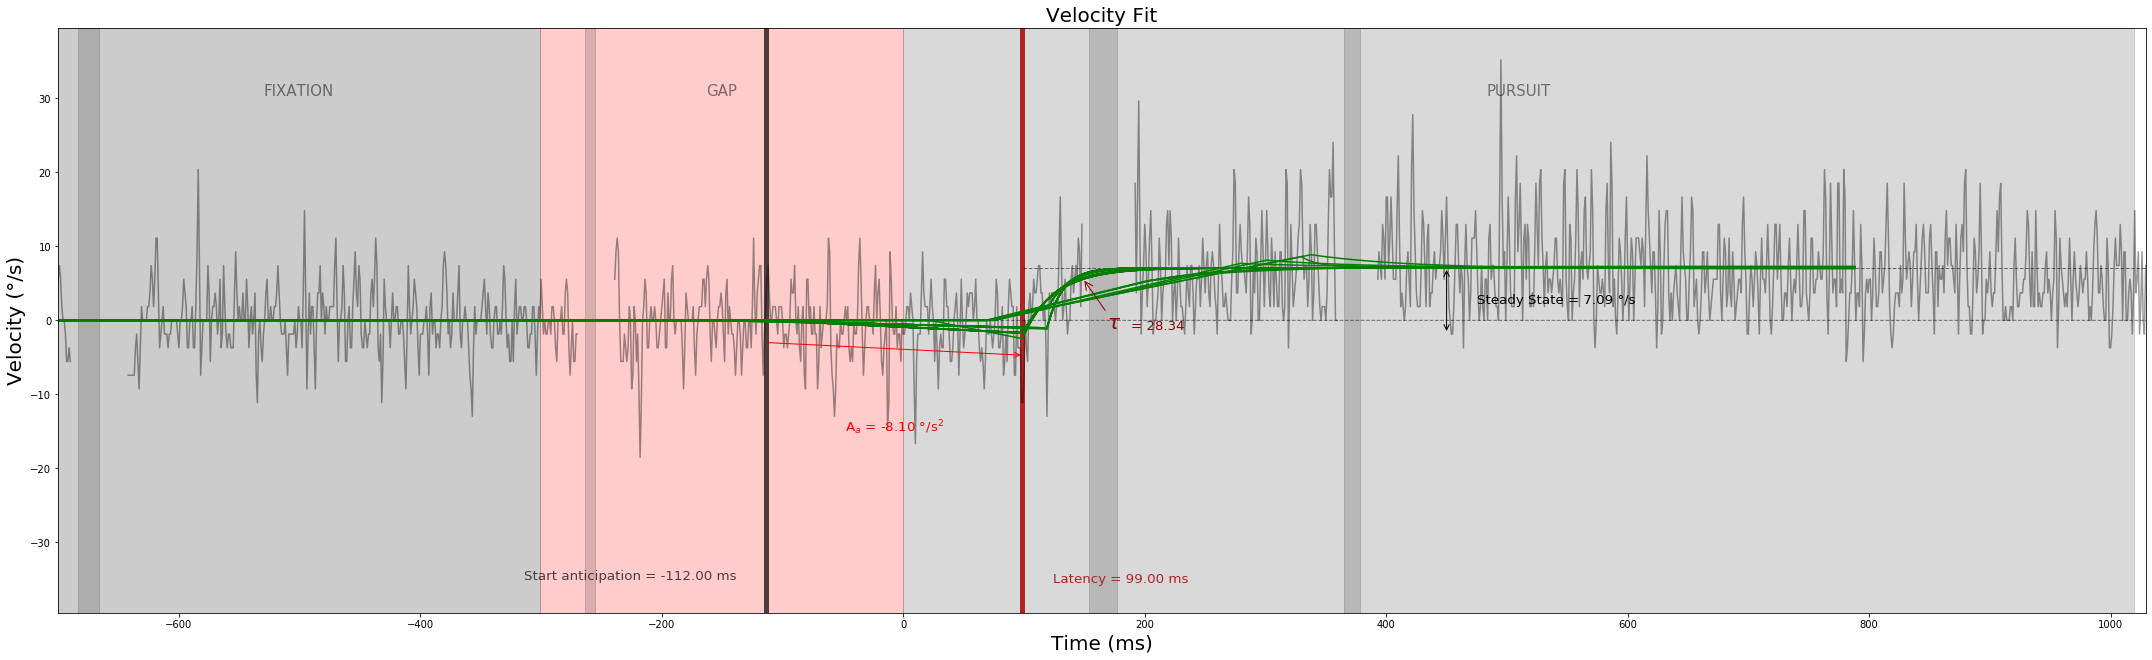

In [12]:
s, t = 4, 49
result_full_data_s4_49, result_red_data_s4_49 = moulti_fit(s, t)

# Hist

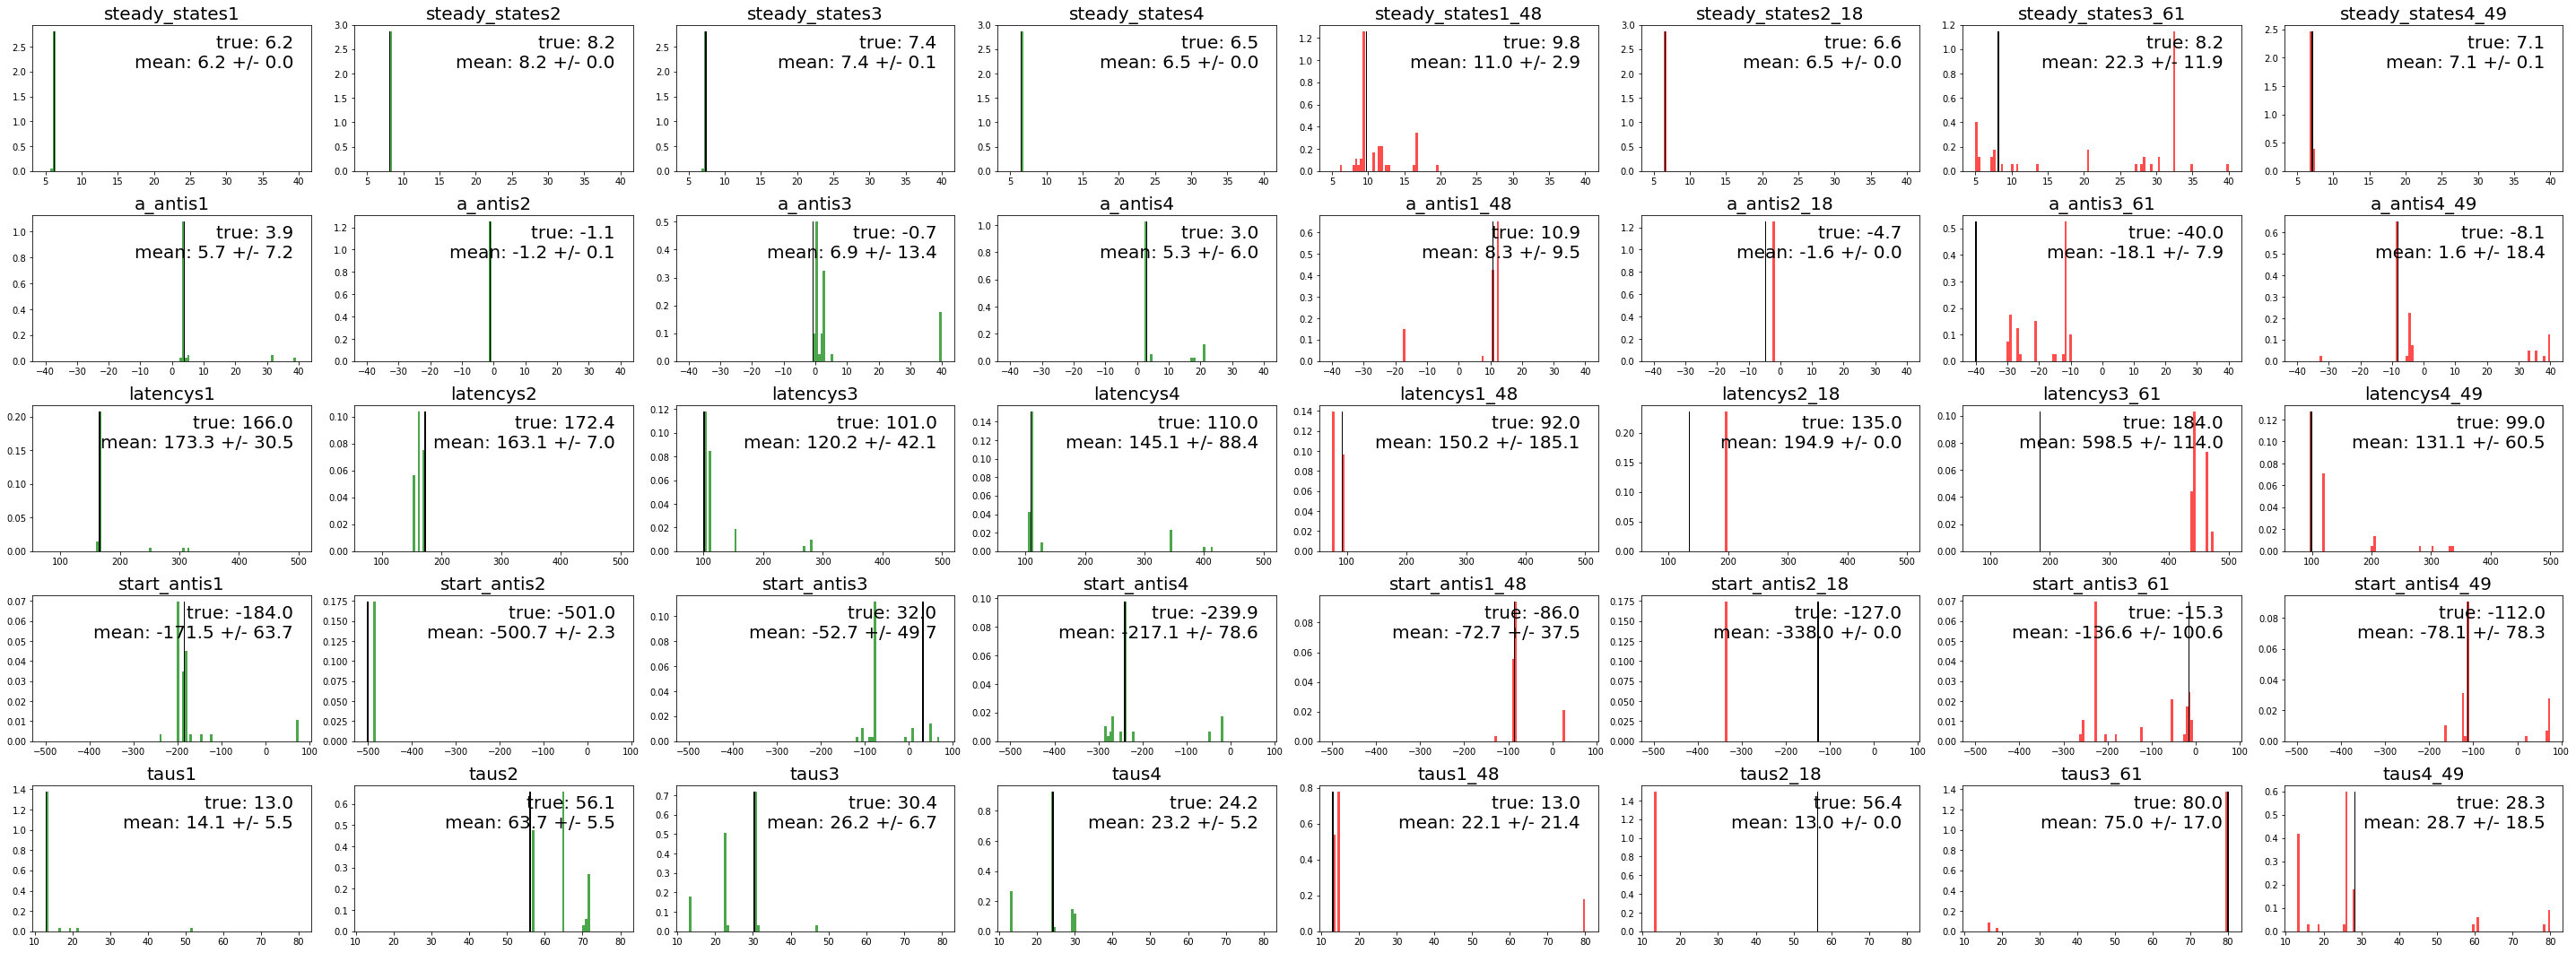

In [14]:
histoto([result_full_data_s1, result_full_data_s2, result_full_data_s3, result_full_data_s4,
         result_full_data_s1_391, result_full_data_s2_18, result_full_data_s3_61, result_full_data_s4_49],
        [result_red_data_s1, result_red_data_s2, result_red_data_s3, result_red_data_s4,
         result_red_data_s1_391, result_red_data_s2_18, result_red_data_s3_61, result_red_data_s4_49],
        ['s1', 's2', 's3', 's4', 's1_391', 's2_18', 's3_61', 's4_49'],
        [ 'g',  'g',  'g',  'g',    'r',      'r',     'r',     'r'], bins=100)